In [24]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os

import detailedbalance as db

font = {'size' : 22}

matplotlib.rc('font',**font)
%matplotlib inline

In [25]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
Egap = 1.1  #electron volts

r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [26]:
E_ph = np.arange(0.01, 10,0.01) 
E_ph = np.flip(E_ph,0)

E_gaps = np.arange(0.3, 5,0.01) 
E_gaps = np.flip(E_gaps,0)


emissivity = db.gen_emissivity(1,1,1.1,E_ph)

#emissivity =db.lor_emissivity(0.1,1,1.25,0.1,E_ph)

BB_5500K = db.solar(5750,E_ph,emissivity)

BB_2500K = db.solar(2550,E_ph,emissivity)

BB_5500K_ph = db.power_to_photons(BB_5500K)

#check integrated irradiance is ~1kW/m^2
integrate = -np.trapz(BB_5500K[:,1],BB_5500K[:,0] )
print(integrate)

print(db.stephan(5750)*4*pi*r_sun**2)

1330.6241976066626
3.762263521545546e+26


Text(0.5,1,'Spectral Irradiance')

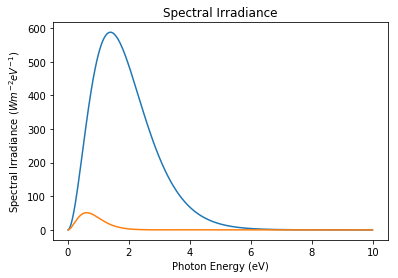

In [33]:
plt.plot(BB_5500K[:,0],BB_5500K[:,1])
plt.plot(BB_2500K[:,0],BB_2500K[:,1])
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Spectral Irradiance ($Wm^{-2}eV^{-1}$)')
plt.title('Spectral Irradiance')

Text(0.5,1,'Spectrum Irradiance')

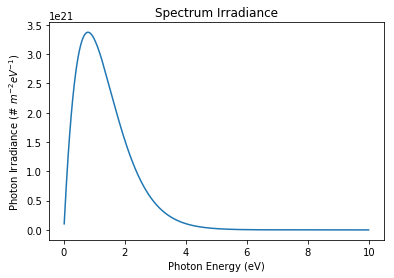

In [34]:
plt.plot(BB_5500K_ph[:,0],BB_5500K_ph[:,1] )
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Photon Irradiance (# $m^{-2}eV^{-1}$)')
plt.title('Spectrum Irradiance')

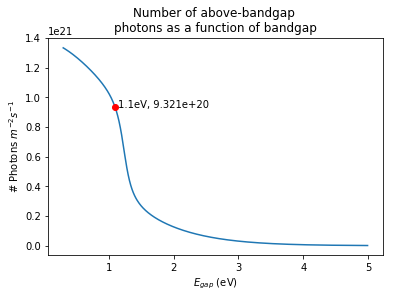

In [6]:
db.photons_above_bandgap_plot(BB_5500K_ph,E_gaps)

In [27]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', db.jsc(Egap, BB_5500K_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', db.voc(Egap, BB_5500K_ph), 'V')


#watch out for minus 1

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  525.5159804518255 A/m^2
Ideal open circuit  voltage:  0.8619183718625414 V


In [28]:
db.recomb_rate_v(.1,BB_5500K_ph, .1)

recomb rate with correct voltage 


83539.47408806968

In [9]:
db.voc(.2, BB_5500K_ph)

0.021911030530979935

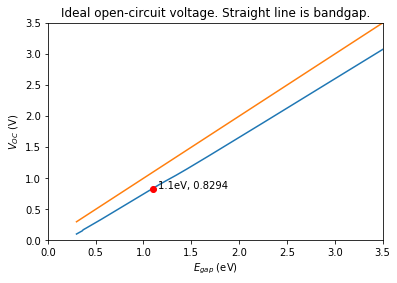

In [10]:
db.ideal_voc_plot(BB_5500K_ph,E_gaps)

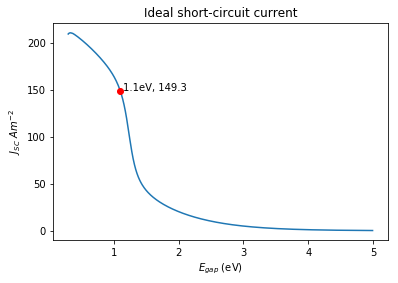

In [11]:
db.ideal_jsc_plot(BB_5500K_ph,E_gaps)

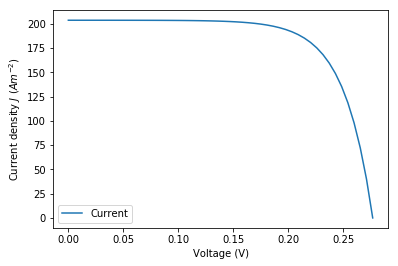

In [12]:
db.iv_curve_plot(0.5, BB_5500K_ph)

In [13]:
print('For a cell with bandgap %.2f eV' % Egap)
print('max power %.2f' % db.max_power(Egap, BB_5500K_ph) )
print('Irradiance %.2f' % db.int_irr(Egap, BB_5500K_ph ))
print('Ideal efficiency is {:.4}%'.format(db.max_eff(Egap, BB_5500K_ph)*100))

For a cell with bandgap 1.10 eV
max power 107.02
Irradiance 282.00
Ideal efficiency is 37.95%


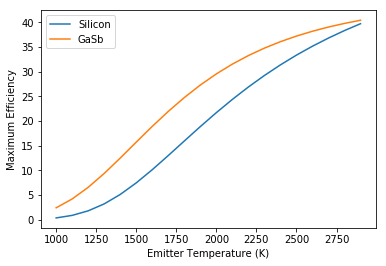

In [14]:
#generate multiple blackbody spectra


max_eff_all_Si, max_eff_all_GaSb, max_pow_all_Si,max_pow_all_GaSb = db.max_eff_temp(E_ph,emissivity, 1000,3000,100, 0)
#spectra_ph_all


ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Emitter Temperature (K)')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))
#plt.legend(max_eff_all_Si,'Si')

Text(0,0.5,'Emissivity')

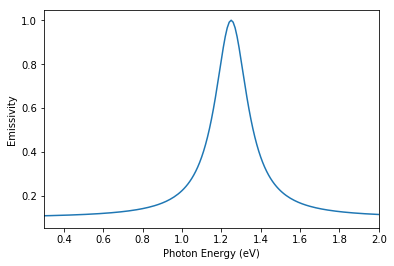

In [15]:
plt.plot(E_ph,emissivity)
plt.xlim((0.3,2))
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Emissivity')

Text(0,0.5,'Maximum Power (W/m^2)')

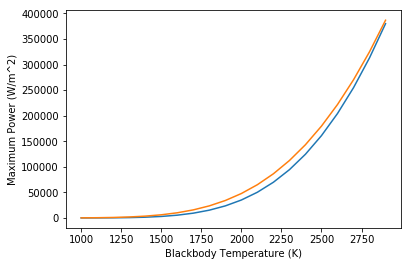

In [16]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')

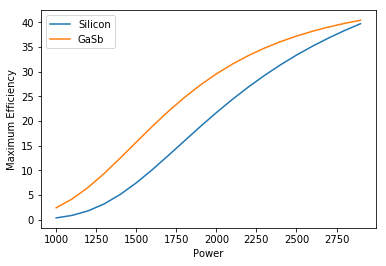

In [31]:
#generate multiple blackbody spectra now with the solid angle set to half 

import pandas as pd

max_eff_all_Si_pow, max_eff_all_GaSb_pow, max_pow_all_Si_pow,max_pow_all_GaSb_pow = db.max_eff_power(E_ph,emissivity)
    
ln1 = plt.plot(max_eff_all_Si)

ln2 = plt.plot(max_eff_all_GaSb)
lns = ln1 + ln2
plt.xlabel('Power')
plt.ylabel('Maximum Efficiency')
plt.legend(lns, ('Silicon','GaSb'))

Text(0,0.5,'Maximum Power (W/m^2)')

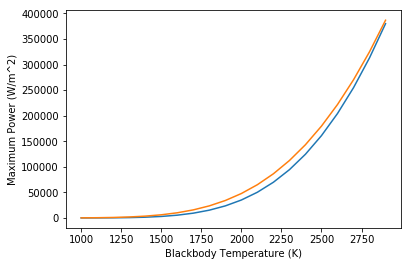

In [30]:
plt.plot(max_pow_all_Si)

plt.plot(max_pow_all_GaSb)
plt.xlabel('Blackbody Temperature (K)')
plt.ylabel('Maximum Power (W/m^2)')



In [19]:
print("Silicon cells")

print("efficiency " , max_eff_all_Si[2500])

print("power ", max_pow_all_Si[2500])
print("stephan ", db.stephan(2500))

print ("efficency from stephan" , max_pow_all_Si[2500]/db.stephan(2500)*100)

Silicon cells
efficiency  33.377525886898475
power  160903.99350418826
stephan  2214987.109375
efficency from stephan 7.264330921979512


In [20]:
print("GaSb cells")


print("efficiency " , max_eff_all_GaSb[2500])

print("power ", max_pow_all_GaSb[2500])
print("stephan ", db.stephan(2500))

print ("efficency from stephan" , max_pow_all_GaSb[2500]/db.stephan(2500)*100)

GaSb cells
efficiency  37.240477673765085
power  179526.23564781452
stephan  2214987.109375
efficency from stephan 8.10506909444142


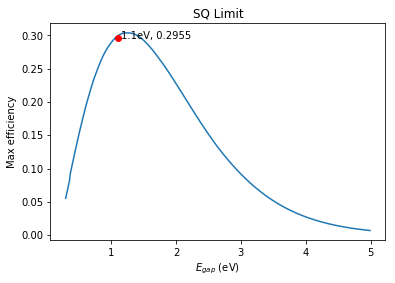

In [29]:
db.sq_limit_plot(BB_5500K_ph,E_gaps)

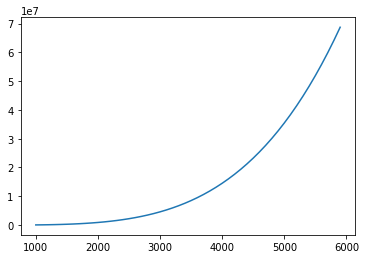

In [32]:
Temp = np.arange(1000.0, 6000.0,100.0)
Rad = np.copy(Temp)

for i in range(len(Temp)):
    Rad[i] = db.stephan(Temp[i])

plt.plot(Temp,Rad)